<center><img src='https://drive.google.com/uc?export=view&id=12CrUdXDAiltLBT26sG7HZ_HciIhvGyT8'></center>

# Wstęp do uczenia maszynowego - Notebook 11, version for students
**Author: Jacek Sroka**


In this class you will learn about:

1. Maximal Margin Classifier,
2. Support Vector Classifier,
3. Support Vector Machine,
4. Using SVMs with more than two classes.




Below are some helper function we will use in the notebook.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math, sys
from sklearn import datasets, svm

def plot_data(plt, x1, x2, y, xlabel, ylabel, clabels):
  scatter = plt.scatter(x1, x2, c=y, cmap=plt.cm.Set1)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(handles=scatter.legend_elements()[0], labels=clabels)
  plt.grid()
  x_buff = (x1.max()-x1.min())/10.
  y_buff = (x2.max()-x2.min())/10.
  x_min, x_max = x1.min() - x_buff, x1.max() + x_buff
  y_min, y_max = x2.min() - y_buff, x2.max() + y_buff
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)


def plot_border(ax, clf):
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  xlin = np.linspace(xlim[0], xlim[1], 30)
  ylin = np.linspace(ylim[0], ylim[1], 30)

  # circles around support vectors
  ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
  )

  xy = np.transpose([np.tile(xlin, ylin.size), np.repeat(ylin, xlin.size)])  # carthesian product
  dist_from_border = clf.decision_function(xy).reshape((ylin.size, xlin.size))
  ax.contour(xlin, ylin, dist_from_border, colors='k',
             levels=[-1, 0, 1], alpha=0.5,  # plot only levels equal to -1, 0, 1
             linestyles=['--', '-', '--'])

## Maximal Margin Classifier

This week we are going to deal with another type of classification. Let us recall the [Iris](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) dataset from the scikit-learn. We project it to the first two features (Sepal length and Sepal width) and adjust the target so that we have 0 for setosa and 1 for versicolor and virginica. We get the following graph.

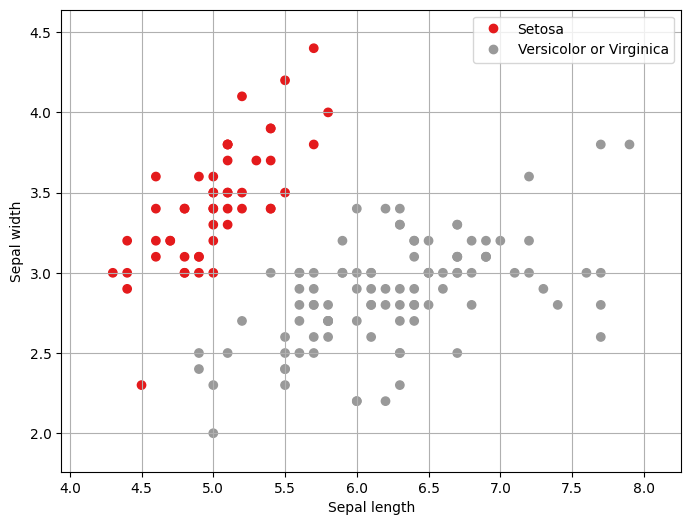

In [ ]:
iris = datasets.load_iris()  # setosa, versicolor, virginica
# print(list(iris.target_names))  # ['setosa', 'versicolor', 'virginica']
X = iris.data[:, :2]  # Sepal length and Sepal width
y = list((iris.target != 0).astype("int"))  # [0 for setosa and 1 for versicolor and virginica]

plt.figure(figsize=(8, 6))
plot_data(plt, X[:, 0], X[:, 1], y, "Sepal length", "Sepal width", ["Setosa", "Versicolor or Virginica"])

plt.show()

In this example, it is possible to separate the classes by drawing a line, which would be defined by: $\beta_0+\beta_1x_1+\beta_2x_2=0$ for some $\beta_0$, $\beta_1$ and $\beta_2$.

In general, for the $p$ dimensional case, points may be separable by a hyperplane that is a $p-1$ dimensional affine subspace (subspace shifted from the origin). Points on the hyperplane satisfy the equation: $\beta_0+\beta_1x_1+\ldots+\beta_nx_p=0$ for some $\beta_0, \beta_1, \ldots, \beta_p$. Note that if we consider $i$th observation $\mathbf{x_i}=(x_{i1}, \ldots, x_{ip})$ the sign of $\beta_0+\beta_1x_{i1}+\ldots+\beta_{p}x_{ip}$ determines on which side of the hyperplane a point lies.

The parameters of hyperplane equation are not uniquely determined, because $\beta_0, \beta_1, \ldots, \beta_p$ and $k\beta_0, k\beta_1, \ldots, k\beta_p$ result in the same equation for $k \neq 0$. To enforce uniquness we will require $\sum_{i=1}^{p}\beta^2_i=1$. With this constraint a perpendicular distance from the $i$th observation $\mathbf{x_i}=(x_{i1}, \ldots, x_{ip})$ to the hyperplane is: $\beta_0+\beta_1x_{i1}+\ldots+\beta_{p}x_{ip}$.

Even with this extra requirement the hyperplane does not need to be unique. Usually we could also shift the hyperplane a little and it would still separate the data. Intuitively the best (optimal) hyperplane would have the biggest margin, i.e., distance from the closest points from both classes. We call it the *maximal margin hyperplane*. Parameters defining it are solutions to the following optimization problem: find $\beta_0$, $\beta_1$ and $\beta_p$ that maximize $M$ subject to (1) $\sum_{i=1}^{p}\beta^2_i=1$ and (2) $\forall_{i=1..n}y_i(\beta_0+\beta_1x_{i1}+\ldots+\beta_{p}x_{ip}) > M$, where  $y_i \in
\{−1, 1\}$ defines the class for $\mathbf{x_i}$.

If a maximal separating hyperplane exists we can use it to obtain a very natural classifier.

Let us draw the maximal separating hyperplane for our example (solid line). The points in circles are the closest ones and they alone define the hyperplane. The dashed lines define the margin to the maximal separating hyperplane. They are called *support vectors*.


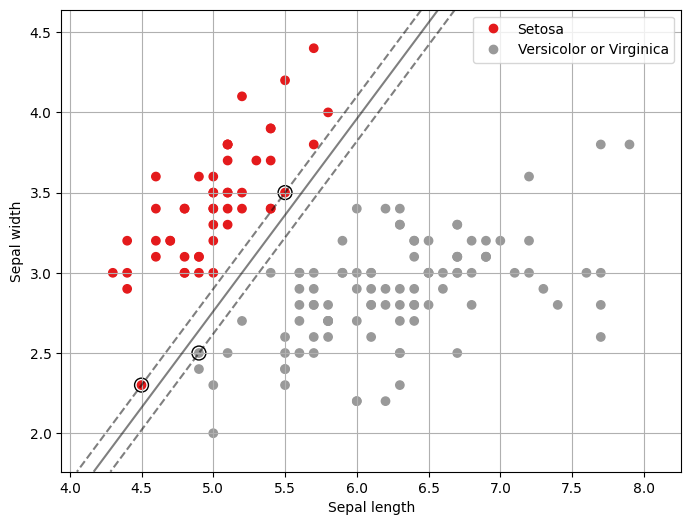

In [ ]:
iris = datasets.load_iris()  # setosa, versicolor, virginica
# print(list(iris.target_names))  # ['setosa', 'versicolor', 'virginica']
X = iris.data[:, :2]  # Sepal length and Sepal width
y = list((iris.target != 0).astype("int"))  # [0 for setosa and 1 for versicolor and virginica]

plt.figure(figsize=(8, 6))
plot_data(plt, X[:, 0], X[:, 1], y, "Sepal length", "Sepal width", ["Setosa", "Versicolor or Virginica"])

clf = svm.SVC(kernel="linear", C=sys.maxsize)  # strength of the regularization is inversely proportional to C
clf.fit(X, y)
ax = plt.gca()

plot_border(ax, clf)

plt.show()

## Support Vector Classifier
The Maximal Maring Classifier isn't always possible to obtain, as the classes may not be linearly separable. Even if the classes are linearly separable and a maximal margin classifier can be obtained, it may have a very small margin.

In the example below adding a new point to the dataset introduces a big change to the maximal margin hyperplane and decreases the margin a lot. This is a reason to try to get a big margin even at the price of some points being inside it or on the wrong side of the border.

We introduce a new classifier called *Support Vector Classifier* (also called *Soft Margin Classifier*). The hyperplane is chosen to correctly classify as many points as possible. There is an additional tuning parameter $C$ that controls how strict we are. The parameters defining the hyperplane are now solutions to the following optimization problem: maximize $M$ subject to (1) $\sum_{i=1}^{p}\beta^2_i=1$, (2) $\forall_{i=1..n}y_i(\beta_0+\beta_1x_{i1}+\ldots+\beta_{n}x_{in}) > M(1-\epsilon_i)$, (3) $\forall_i \epsilon_i \geq 0$ and $\sum_i \epsilon_i \leq C$, where $\epsilon_i$ are called *slack variables* and allow individual variables to be on the wrong side of the margin, or for $\epsilon_i > 1$ on the wrong side of the border.

Check the following abstract example and play with the value of $C$ for the third figure. Note that $C$ in the definition from the book (above) and in the library implementation are inversely proportional (see [mathematical formulation for the library implementation](https://scikit-learn.org/stable/modules/svm.html#mathematical-formulation) for details).

Note that the location of the border/size of the margin depends only on the points that are not on the right side of the margin (we call them *support vectors*). We could move the remaining points around and unless they don't touch the margin or move to the other side of the border nothing would change. This is different from methods like LDA where the mean of all the the values plays a role. By controlling the value of $C$ we can control how many points are inside the margin or are misclassified, which results in another type of bias-variance tradeoff. In the SVC implementation low regularization (high C) results in highly variable border, because it depends on each observation; high regularization (low C) shifts the border from the optimal one that gives the best separation, which can be interpreted as a bias.

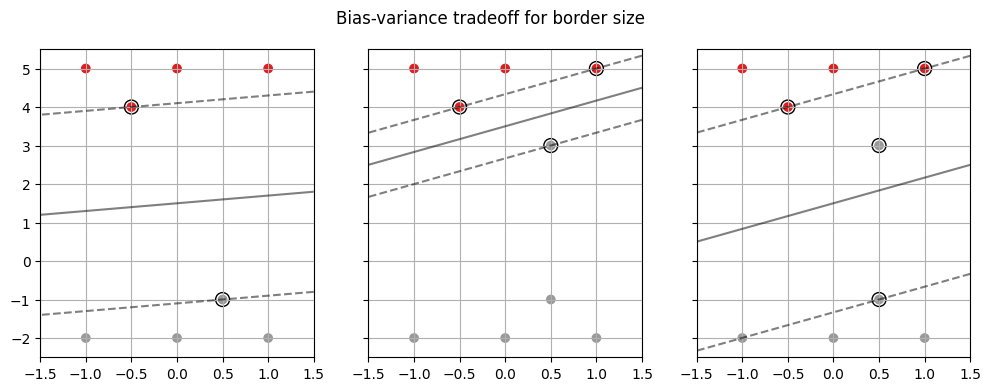

In [ ]:
X = np.array([[-1, 5], [0, 5], [1, 5], [-0.5, 4], [-1, -2], [0, -2], [1, -2], [0.5, -1], [0.5, 3]])
y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# Initialize the plot - create scatter plots with the data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4))
fig.suptitle("Bias-variance tradeoff for border size")
ax1.scatter(X[:-1,0], X[:-1,1], c=y[:-1], cmap=plt.cm.Set1)  # without the new point
ax1.grid()
ax2.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Set1)  # with the new point
ax2.grid()
ax3.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Set1)  # with the new point
ax3.grid()
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Create a classifier object. We will call it's .fit() method along with plotting
# strength of the regularization is inversely proportional to C;
# C = 10 in this case gives almost no regularization, C = 1 gives a minimal one
clf = svm.SVC(kernel="linear", C=10)

# Call the classifier and plot its result
clf.fit(X[:-1], y[:-1])  # without the new point
plot_border(ax1, clf)

clf.fit(X, y)  # with the new point
plot_border(ax2, clf)

# Create a classifier object with a higher regularization.
# strength of the regularization is inversely proportional to C;
# C = 0.3 gives a relatively strong regularization
clf = svm.SVC(kernel="linear", C=0.3)
clf.fit(X, y)  # with the new point
plot_border(ax3, clf)

plt.show()

### Exercise 1
Find the best value of $C$ for `svm.SVC` with the linear kernel (as in the example above). Use the iris dataset with sepal length and width. This time your goal is to distinguish virginica from setosa and versicolor. Try values $C$ from 0 to 1. For each value do a k-fold cross validation (see [RepeatedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html)). Evaluate the score with [cross_val_score](sklearn.model_selection.cross_val_score) by maximizing accuracy (`scoring="accuracy"`). Using the `plot_border` function defined at the beginning of the notebook, plot the border and margin for your value of $C$ and print the accuracy score.

Hint: You can try several values of $C$ in a loop. If you want to learn something extra try [grid_search](https://scikit-learn.org/stable/modules/grid_search.html) or [optuna](https://optuna.org/).

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.6 MB/s eta 0:00:00


[I 2024-05-13 12:48:22,604] A new study created in memory with name: Minimize 1-mean(accuracy)


Optuna Version : 3.6.1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2024-05-13 12:48:25,918] Trial 0 finished with value: 0.19777777777777783 and parameters: {'C': 0.8753663173375029}. Best is trial 0 with value: 0.19777777777777783.
[I 2024-05-13 12:48:26,068] Trial 1 finished with value: 0.19777777777777772 and parameters: {'C': 0.5897585686286697}. Best is trial 1 with value: 0.19777777777777772.
[I 2024-05-13 12:48:26,279] Trial 2 finished with value: 0.2088888888888888 and parameters: {'C': 0.288774414296358}. Best is trial 1 with value: 0.19777777777777772.
[I 2024-05-13 12:48:26,382] Trial 3 finished with value: 0.21111111111111092 and parameters: {'C': 0.1817402979199224}. Best is trial 1 with value: 0.19777777777777772.
[I 2024-05-13 12:48:26,542] Trial 4 finished with value: 0.19777777777777783 and parameters: {'C': 0.8763404790903131}. Best is trial 1 with value: 0.19777777777777772.
[I 2024-05-13 12:48:26,728] Trial 5 finished with value: 0.24444444444444424 and parameters: {'C': 0.05312678745474919}. Best is trial 1 with value: 0.197777

Best Params : {'C': 0.6111573755255655}

Best mean(accuracy) : 0.8044444444444445



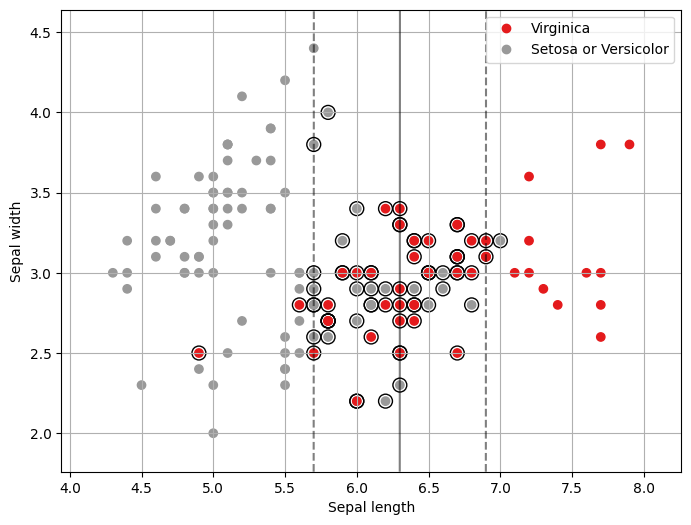

In [ ]:
# put your code here


### Exercise 2
Note that `svm.SVC` supports multiclass classification which is handled according to a one-vs-one scheme. Repeat the previous exercise on iris dataset with sepal length and width and all the classes. Try values $C$ from 0 to 10. This time visualize the result with `DecisionBoundaryDisplay.from_estimator`.

[I 2024-05-13 13:03:11,431] A new study created in memory with name: Minimize 1-mean(accuracy)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


[I 2024-05-13 13:03:12,893] Trial 0 finished with value: 0.21111111111111092 and parameters: {'C': 2.0716833567814996}. Best is trial 0 with value: 0.21111111111111092.
[I 2024-05-13 13:03:12,993] Trial 1 finished with value: 0.20666666666666655 and parameters: {'C': 9.69777832308502}. Best is trial 1 with value: 0.20666666666666655.
[I 2024-05-13 13:03:13,099] Trial 2 finished with value: 0.20222222222222208 and parameters: {'C': 5.0896128543525005}. Best is trial 2 with value: 0.20222222222222208.
[I 2024-05-13 13:03:13,234] Trial 3 finished with value: 0.2088888888888888 and parameters: {'C': 6.8299332459972115}. Best is trial 2 with value: 0.20222222222222208.
[I 2024-05-13 13:03:13,329] Trial 4 finished with value: 0.20222222222222208 and parameters: {'C': 4.826855814955247}. Best is trial 2 with value: 0.20222222222222208.
[I 2024-05-13 13:03:13,430] Trial 5 finished with value: 0.2088888888888888 and parameters: {'C': 3.605691156982976}. Best is trial 2 with value: 0.20222222222

Best Params : {'C': 0.4232495636955135}

Best mean(accuracy) : 0.8022222222222225



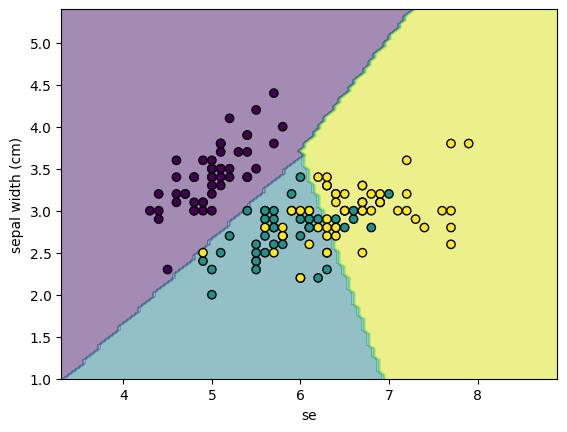

In [ ]:
# put your code here


### Exercise 3
Read the [Tips on Practical Use](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use) and check if SVM requires feature scaling/normalization and how to do it. If needed, extend your solution to the previous exercise and see if anything changes. Did the location of the border change a lot? Why/Why not?

Hint: check [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) and [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

[I 2024-05-08 13:01:59,907] A new study created in memory with name: Minimize 1-mean(accuracy)
[I 2024-05-08 13:02:00,118] Trial 0 finished with value: 0.21999999999999986 and parameters: {'C': 0.08874705546304607}. Best is trial 0 with value: 0.21999999999999986.
[I 2024-05-08 13:02:00,472] Trial 1 finished with value: 0.2155555555555554 and parameters: {'C': 0.13547510354980563}. Best is trial 1 with value: 0.2155555555555554.
[I 2024-05-08 13:02:00,786] Trial 2 finished with value: 0.20666666666666655 and parameters: {'C': 0.24163168070658747}. Best is trial 2 with value: 0.20666666666666655.
[I 2024-05-08 13:02:01,111] Trial 3 finished with value: 0.19777777777777772 and parameters: {'C': 0.8886225134522857}. Best is trial 3 with value: 0.19777777777777772.
[I 2024-05-08 13:02:01,406] Trial 4 finished with value: 0.19999999999999996 and parameters: {'C': 0.5591597693436849}. Best is trial 3 with value: 0.19777777777777772.
[I 2024-05-08 13:02:01,678] Trial 5 finished with value: 0.

Best Params : {'C': 0.757873484936897}

Best mean(accuracy) : 0.8066666666666668



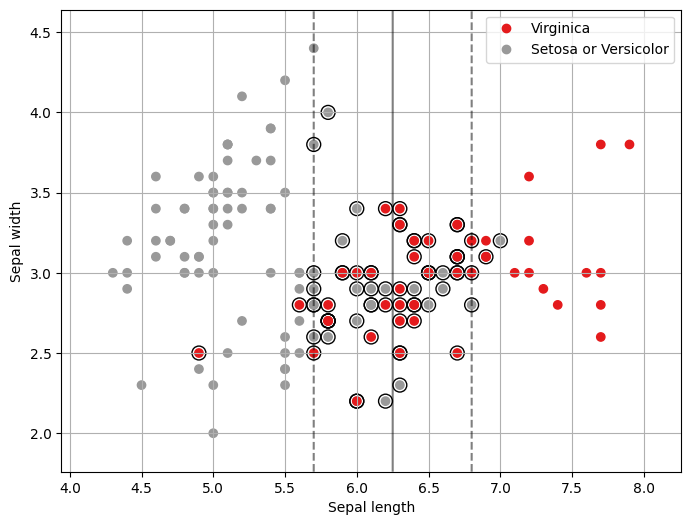

In [ ]:
# put your code here


## Support Vector Machine
To deal with non-linear boundaries we could extend the feature space by applying some functions to predictors, e.g., rather than using $x_{i1}, \ldots, x_{in}$ we could use $x_{i1}, x_{i1}^2, \ldots, x_{in}, x_{in}^2$ or $x_{i1}, \sqrt{x_{i1}}, x_{i1}^2, \ldots, x_{in}, \sqrt{x_{in}}, x_{in}^2$. In the enlarged feature space, the decision boundary would be linear, but in the original feature spaces, it wouldn't anymore.

A similar effect can be achieved with a Support Vector Machine (SVM), which is an extension of the support vector classifier where rather than adding transformed predictors, the feature space is extended with *kernels* to allow an efficient computational approach. The classifier can be represented as: $f(x)=\beta_0+\sum_{i=S}\alpha_i K(x, x_i)$, where $x$ is the instance we want to classify, $\alpha_i$ are parameters determined while training, $x_i$ are training observations and $S$ is the set of indexes of the support vectors. The $K(x, x_i)$ is called a *kernel*. $f(x)$ returns the decision score, which is used to predict the class label of the input $x$.

For $K(a, b) = \langle a, b\rangle = \sum_{j=1..n}a_j b_j$ (a linear kernel) we get $f(x)=\beta_0+\sum_{i=S}\alpha_i \langle x, x_i\rangle$. This sum can be rearranged so that it is clear that $f(x)$ is a linear function of the coordinates of x and that there is correspondence between $\alpha_i$ and $\beta_i$.

Some other interesting kernels include:
* $K(a, b) = (1+\sum_{j=1..n}a_j b_j)^d$ --- a polynomial kernel of degree $d$ ( essentially amounts to fitting a support vector classifier in a higher-dimensional space involving polynomials of degree $d$),
* $K(a, b) = e^{-\gamma \sum_{j=1..n}(a_j - b_j)^2}$ --- a radial kernel (has very local behavior in the sense that training observations that are far from $a$ play a small role in classifying it).

Training a classifier with kernels rather that extending the feature space has computational advantages when number of features is large or infinite.

## Homework 1
Extend your solution to test other kernel functions implemented in the [library](https://scikit-learn.org/stable/modules/svm.html#kernel-functions) and plot the result for each of them. Note that the kernels have additional parameters (except the linear one). Check [this](https://www.kaggle.com/code/gorkemgunay/understanding-parameters-of-svm) to get the intuition on how they work. Determine best values for them as well as for the `C` parameter. Note that for the sigmoid kernel the values should be between 0 and 1 (use [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) rather than `StandardScaler` as for other kernels). Use the following dataset.

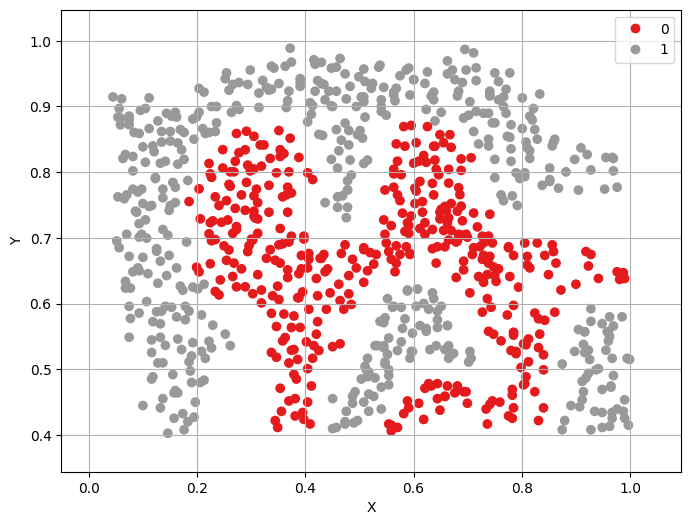

In [ ]:
import scipy.io
import base64

with open("svm2.mat", "wb") as fh:
    fh.write(base64.decodebytes(b'TUFUTEFCIDUuMCBNQVQtZmlsZSwgUGxhdGZvcm06IEdMTlhBNjQsIENyZWF0ZWQgb246IFN1biBOb3YgMTMgMTQ6Mjg6NTQgMjAxMSAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAABSU0PAAAA5RwAAHicdFkHWI3v+z8iMzMr2SPzi5bxDXeEjLKpyG7wRSIzo+wVSUZli6wklWQ2lJIT7ZxK43RWZ5W99T/9zvk873Xl+nO57uu87/M+z/3c43N/7lsLHo/XfRiP11AjG/O0svaPvu734vo8np5G1tP8ddTIJpp/1ZY8XlbGH+uHax5TDb/7mMiKBxTbVnE3qvVDGsB7Yb5C9pzWmzbMX/crnZZIrL4dqp9H20MCOwT7FlFu8LZJ30oqSM/t2Z6LI2S0mq84aDNMTvHBQYOT5ZWkPV1GqR8ivBOeyKizSaerZTdllOJX/aX7XhmV2dl1WPZZxtat/fhi8tJFMmpvnlS0p5WcyQT+5mrDRkK6wev45tLlUvLyXXKsa3wJLbK/EBUSUUxXfHYfaWdZRDGS1MXzc4vJ6Oj2Re/nlNFc81X9u6tKqepVsKrpjnw6Jl742XdrFsn5o3tvr8qgvu791FsCX9Ej94WhYutE6hnxdVPYwGhS+kt2jm4XQc1/GzqH33hIoa+LbZK+PqMol9odEsg9JPK3i18ijVweZBjz8iltXuHo9yj/EcGO09puHxxh94BcCxqFhrrdYxL2NQ2KHydJTybbV7u6/lf0gjzMbhlUeCTRQPNrnx80eELGrr/dlj1Kol4r+L3l+s9pr+tqmZtPMv023/Mt4Vg8O690r3TKzeoYpq++88RLkd5xbL9AnuX91XdSaOTZYzyP9ik0eeUw/+dLnrHzz9Qc3/nz39e0krd2V4OULLpsF/oypWMOycwvlfiF5NEpt48jDCR59MloxtqJGdl0wN5Foncmk+YF978T3yeTvC3yAr/bvqJVwQapH43SKfJV9UWPS2nEj+q7K2NkAV2I1t+b/7yQxYtl9Gm97D9vmcT75KBPX2dtKaQ1NelTAmcV0oOo8e7BE94R8W7anyt+Rx4J0gOtx5XRej8X/xnRZdQ/Q7KuI7+I+V9jnEvFsdw6C/u3O81elFEHt8vncwYJdecI6bPdENPTlUKdnUVkILl7/KGZmMa6uWdZtZPozhPTKEGG384YKYvTdKPDViUiCYkE4gXd5knpllv+LOtCKQUYjIy9cJmTiGetPSvpmmBUiz1bK+mIUblqbONKtl/36GjZ+abcdzgP55iENbv3I1RMISaryWi5iE6at9385CWnF/LNwveB9W6hjA742d7ce13Ozsdz5FumgbC+1U4xDUkY8+9GVyHN8PrQ09CznOqZlyZO71xGe8yOmnRYXsz8Av/XRmGr2wXk69aq29v3ReRnl3A3oHc5889UiWPJ3JZFOjsX0vWMEc1n7iugQW57HzTqkUvNjfxnNZmex9bDP+P4feYW2ZfQcKO5+9cNLyenhAYe7+wlDAd+rXd7PO5iJRU6fZqm7yynhX67NnaOl1Ck02Dj814SZpdLRsmNNv0SMnz4LkjbOHtKOcv/eW5TFGublDG8yDF/muwYVkT/mU+zmVMuoF52MwcfXczpizzQ2i+T5cfgmh6/v2zk08I/Nj9UijSyNj/YUvkthUJqYc7/Bf3iXR22bn0qy9N9QVNvxZ59QpP2zePfuR/L8v42/2R+aZsEln+ONdKhixclMPy5af71ePXTVJZHwBvgEPBplds/+ld/c3iC99FdlwdefhPJcAE4rrnklj6T5dTK+j/DvpsVDFdDvXYerrCupOnWhkufz66kOTw/98zMAoaX2bwSvSaHc+h/4RqXS7bSX21Td2UzOwEXgBu7a+64pE7MpfX2u/ivr+QziX3O+5ok7b+eTSWSo4FJTzKpPKrp2XqDs2iEncWkxNlZNDsj/JpvzBuGM1gHvD7ufmbtDscMXT5l0TSfL70muOQwPbCf9n7ZlMef33TSzxwKMvO0nuqQz+7lwG+8tuW4tzo8KGS/xwVPDDxims/iH783Gf3Jad62gARBBa0PrM5lddAlKq4mbUMe9QtpFJl2N4fdE+vwHt+XGq2Z20bwlsUfcO9W8P22x78UsHhEHiH/oAfyCbKbb67JNDVnZ3wnFFc6z5wioIO+NjdmRb+l/JqR/DMdilm+ok4CN5Vmv64b9yuhExlzP3YOeMfyXZtXnH44D+fgPfbV4hpXn5HvnrWA5l2mu3+Z7v7lDI+Qx9Xxp5RvD4ooe/2lA4WxYlpg8vz99v0SGqk5jWz+xlnE7zDJxuQexpwEjmA9cBv7vg7r5Xt2gpjVgzCDzpnZp8p1+FfGeMY/wcu3Oowupm8dw0fkzS+ikT6GTVt7CpisW58gf9KB7x92l1Pxh4CTnyKF1Nprct6mwArqY23/z4JVYqpyKlgxcoaI4ZrW/hIdX+H0ldDV0mfHpPQneOz2JalSxqOwDnypbUZ9R1FBpQ4XKqkoPir76kk5w88fBjeGh7pVsrqA+oF6wveZFL+ji5Ri7fZXfDcQ0zm/Ac/jznL4ClzVxkWFLn5ETO8JH3ntv28UMTtivZYXCHV2FDF/wj+ok9r8lVOO27n9N5IUdN/oeo9b1UrST9jSsPkOtY5PVNEru5W//6lXRdsN5p37746KCsyMjknNlfRVzN+0b4yC2QH147FBTWXDwwpqFp35emV7FXmHnen4aoOKIv2av1P6q3XxrGb7notvsq9xHLcfpItX3ihbFwUN/djlV/IuuY5vVjCprdsldMds9nyfqZlUYTG+3R+DDFYPUCdQF4DjO3mzzo54eJsul/fLHVzvOnsPfrcjY71Adu45tbZwa/N590v6dsfUZozNXTrU9fzikdJwtg/qAHDAx9x04cG8HIar2nvk6Oq3gOEP8K9RzAb9ooMcHiDfwauBQ8hr8Llf1ybsOPG4nPUB7gZeu4c9rGC8CnwKcQLeg3wGr2nq+96g0w8R2wd5Cf4GiXjS4pmI1X0tH6ygR4Ju/R6sqaDJviHzY/OFVOiX02ruFuFfeYg4hvwSpYqx7FnB7gN+BJlkNmxDNAl1OMetr7X25gEiljeI74YfHdKcgzm+ArxBXtWV4DPABeg/UxAZFnWjnNrxKowsPpWz++A5cAYS+Qqc2SbYVNgpQMz8AQmchV77nVZILY5wvBD7tWx+ZGbBfC7fUb8QD6ivkOivUAfxHHkB/oB1U6K3dm74MZsUNZ0lr5pxdQVxivNQZ8BPDUN6nz75WMDq0ZiMl0fsEvL+4i3vXYab/8h6zfjAZrt3pxYOLaUX8W/iPC+Vsb4Adm/SyfyQdyJnlwZHg8c/XSLR8TYZqy/X6WdAzygOZ13DYv6c9q1g8VWXZ6Pewa+IIxfrL95fbStYfCGe4WfgC+Lb1knTWUdw8QJ94Z+lRsaaFBAzWbfe4Dz4FfmK+EU+go/fi1deGBUuYXUIfWRmSDeflTOfU2LNvKjlvZIYfwWfDRjtN//2gfus70XfCl6K/hkS+6HfRV+J/dHH9hvdRRCWFM3w7zT/3pPbXWMZH47wH216eUQkw1Vj/8bbLY7cYucCT1P+RG37EJnO6izqEPAdeI86g/rzr/VQW//FVbTId8cGebpSNx9RkJ3RiEvXBnK8GnFyKLrnf1feyJhE34j5CPi4myAwQXJOQSZeg6puHVDp7qUm6fo9l1vcriKrMHX64KAqeiPQG6dYqtLlDTdnAZ6ij4VEXqPfQt+srb+ZVGS60WFTIp+mv55R/N4klc0H4Gf0OZgDoR9BH4P5Bfoj8PNnbg9Xb3j9klSuRStXjX/B/Ah/w4+oX9gXfQ+eY76C8zBXQbxg7oB+YGGn+OopJ3IpvMYraMiQMlaXwcvAT7tIh5UvCi5hsoWdR1unVe+YrPscvBh2DHadrnfWi5s/aflZKeO5+B7rwKdPBWf/WKBXQmZSo58njr5l9Rp4+lJya+uxtHyGh+hbIlzNOr9xf8sk+hXw+0mdivPbX+DmKKjvmKfgN/oC8Ff07eDR4E/IB8Qx5hfAu4sS0QSTMo5f4jck5hGIU/Aw8NMZYVmiZX4cjiI/gDM4DzLZxMxr11Quf8BbrbxaNindJmU4DdwC38AcBfhWl98CP4GvwGnwAPAQ4Dv4CfgH9kFdBX6C7wLvTU1+P217Qchwvu45iBvMLYw//is8frSMvYcErz4sqTfog6KMzW96+wytLt5Wyr5Dn4X1eI44zRA3tOkyr5TFM+pi3X4NfSLiGOsxz8F7fF/uM1Bwr3U5m+tAzxSn1pZZ7mVsvgH8rR98fkLVnDTdnCaN/XatZxi3cfhLNm8Bf8ZcFHih5f/Jf803UYfAv4FDWI95TUf+4h5erulsDgzeDtyBBG5hzoL6hPkE5qHo5xAP2vmRhM31MF8Bv0be4lzMP8CPMC8BvgKvgXuwJ+4RFuI0td7KN2w99sU8pe736CswX6nP396I1mUyvgZc/e7e8P2uLm/YOvAq6Aleh3kM5h+Yo2AejHuDf9TlPeDj4F+QWtyU0EZJ1zbPvkr+mpvC7lr9uL4D30GCD6HfQN8KiT4B+oAHo/9AHoO/YY4MHAEvA7/e6hU3b5ujmPUDWnxXM14BeddkupO9g5q9d3a6Es2/oqbezT1WNZuuYhL8IIsSUw6HqHT1WcX6V619q6iRyfDD4ffVrM8FnwB/eODjem1yfxUts/uxrf8olW6epdLNQZU63q74f/VD3wyJ99r/L+DWa5w7w6Pobx6D76An+v2694SeZ2vD2ofTC3069Mf9jws0BWlflS7Pqtj54G/QQ9svV5F8gWSDk10F5Z25dj7klYhEj/qL75+QEM9TKfAy0tSd3s5pveIUZNuli0OvxypKaWC5vZmCk9Wr/Us8u6nogirLWN1LSTMvilqcTZOThmReFI6Q08u5g3bOdlTQw6THzsmblbpzlLT+2gX9y0/ktHDmlMbz5lbSzfhFSxN3yCj6XpuP4VflZJxXaZ0/W0kKq/h+Y31U7Dt908z7Qy4p2P4HJ8cdt/VUsPerGwg3/tbT+EmsKaRj1EzPmABF2MkCJdWa2/KkgtxtaiuBgv0ea7BB1UzGSdPgAR1P5cop9wG/MipITs719nn/aCwncYhe8PkUGbWqv/Cn3g8p/Vhk4+k8UUruOa0TMpZJyGvf5ocHq0Q0qih0eLGtiHo0fPRF/1OF7r5C+vx0f1mcn5COeh+cuLlVBW2JtV0b5y+i4bdydoVfF5F+YkXRY03/HNND46FnUrp67NjtgHcyZiern+l7PrWV0+Z8j8eZtf8vUL5wsNBKSQ6RR7dEnVUyO4sHtI/vH66gCN9xo3c0UFCrQM8e/hpeotWL88PVP9779L+qdH5X07IrY5teSFJTaMT9rzdvqUnctGp961IV3Rwy1cryjIqafogOUJiomV+Cn9Rze7ZHSTukHfrIhijZ991PZ3Q+Uaim0kNOQ/Z/ULPvcF66pb6Z1RHOL4WaMp2+itP7f7Szn8YPW2sRWUUrehXY97+rYvpAP+d16+Z49Kyi5Ji16rsXOH9jPe6F9Sap57MTvdU6f/2tz6BJ5u3t3VV0bP5SjWtVOv9wdtX2DUoauGL+MlcLzq7Gn1sdVXeX0yOzG8NGBFTSTocGNQsmV1J6SkfH1HUyWlOriKWM3uz/pekE5Ww/nGv3p6/P1xZqGvhtzcH3nTj7rplzvb7TdE4ividmOLxM9VAzfRG32nxW0KH+AeOHhHL3v1G6745giprlMe6H8/t2WL6kS6qKfYfnyO/dN37yrsaqmYS+s3yeJu3+qdT2/YYqajZuazdbLy5esA/Og93HnjtgGPRazfTDfe4uMdaUVhWLA+Tnz9dDpmQuVjJ97KepDGYv4CSe/x8AAAD//2VYe1hN6RdGNzQkUoYicqmUFNEMWZUwch0y1SiXSJFL5JIo1yjElIgQiUjKNT9pKpKJiKJQnTpnn30u+1zDKIT8Mnuvbz9Pzj/r6Zy997fWu973XWs3vi59rGCKGvQcK3Idzqig8cAt2zi1EjJnrds7Y6kKhJ8mdWkxVEPTqYVJZ4r4OPbSix2XL6jh+N8dlxXuUkOH/z5qmOLqmT4uVgXDQ/4MDBqtgsNZvl8yriqhhjl5WuyihKIlEepgRwXkvBlh9taCAccuZu86a+XQZB9+xy5DDpPLfR6VrpaBtGvjOmOhFMJjNuXFNkogSm42hHGQgONx2z5HqsQksudK4OCfi1sWTJSCocfmAVPCpaAaV2Ttvk0Kkjs20txEGURtGj5tvakcnjUz3T4YM2D3evL4mhkMSFM6HT/1gI+m537en3FDDfGRsZM39VBBnlh8UeCphDtOF8e4JCigh07A504tcjAMPBO60E1FcHs0zy56ri+PH9bdVLBHdPuAEm52fL2981sFRAwdPdUuU/HDdZters6v8FfC2L5351veU0CHMHVN+M8KOG6nBadTfOzX1CNea6kEUxP9oL7lCvDYuqh0W0cF7IqturlfwYDy8fOZ5UEM9Av6uizwVzmU3FyjvZIqg4vCmOwaLxlMsbDwscqXwrNl1fIVw6VweL/j1YO0BHyuxkdcPyHh+i3h+k9D1f+eKK4fE4OvZeScobkUBO7sWxjTJIKQG8rw3CMiKEn67WxypQjGfS7b9d5EzNUjhsCeIyTGAhrsfhtlOiNYCvrGmcvNXkghb86znbMXyKHsQR/f0rUMVBskbuouVRCce5e4vSrcroRjAuvrL2fzuKcGFDYtdlVw5zKQWbRg8b0oBs4dPJiVUM8QfPB6Nk+G8Gr4x1Wxb/vKSN15xfn+JZskkN7/bKVFCQ3BE1uPu2+lub6IufPFXB8o7nyK/J6qqeyntZJwepBAnE2Cp0O6FIaWnnp+L1JG+oDnz5ip+Wnu/Lbfx+677JxEw/TVJn6h1jRIbU2LbC7TEEAFjBCPk0B18vlTKY8l8GbloYawAVJyX6bDtHHOyVJyTvs6Sgb7P7S6TcPvpyXdTzwUQ3O3thNqKI4XIg4nEccbClatfzprrTkNEbemrLl9SEKeV+as5zRuvxSUqk8pUieeN8ijru9uJKiGykg+qE/kEfY7tubxrRd/yAgemDfy4IGu81ZDFa/PnRc/dzh3SwaWR8vNE2tlEHjWvWtqMe8DeD3qfM62guKdnyUEt9ipt/+aEkZDznYP1yhdGm5c6/nv5XM8b8dP+8t49mKK8x8KPk8wH+y5mYIxZS3lJevFsO58ql7a37yfsL7G14V+cq41Mkbvw48R8WD796M/snmqoejf/T3fm6nh81MHr4qFag5/NRiHT63e2EsDq7wv6PjN0oDjZp0nWw00xFfZ/Hles7pjQD/t70Ppebx/oR7QZ9j6ef9A30B/Y3nD+zXLHyWHC69DjKhT9HPUpWi5E71qSJs/Hg4beEikJM9jdaclcZjZkkUWpRrO57UEL8QJ5wfm1a9a4fZyblv93Jxi+6+BK4v6vV06VkP8uv11LJ/531m9qjmdqwjPELd1vfcLTV7KCW9RB8jv2ocb5paF8jpj/Z4G/44xkS2dxURn7FwREV2hHtB3ke/oC/5r13qvHiQn399MUGUkveL5h/p/1EY14QReF3hf4a7TLttbZbBSV7zhayfe39CX0K/YftNcX2hw/2m9xpChiU+jblAP7JwRQ9Jni32dvlLET9j5REGtS6D9hBiK6zsFAzdmVGzu9qPfYMS5gRG/j807tyI/TgSGzw9MeuEnIs9DXH0qbpaUhfDzHnWOfdjVh6k1q6B/0H/A716d/5hHcfrgnz+9ocMooTt/Lv7O8kBE6saI+eD1iAerAzE3r3h8MbL6lxAfRf+s9Y3b/MccObif3Nvr2FMZVA3Luz/0upzsQ6u+E8GZgZsDvz2xLJSDMM7PYc87vr+sP0gJT9Cf2s8vxA9xQP8j86d12LYP3WUQMXn+Ec+NcrLX4FxF3oVYvZphc4X3Ocwb68B5jnsbqz8J5z/83ER+4P6CfoH1tok6zH8yz2fkN+aHe1v7uc/6uIKrV8nxRUm+x+tRb4f7TXrZt0xO8EX88flsngrir0MvbNyTmc3AQeV6S5UNv6/ifahb9H/co1ieKLg5qyJ1o+/iHEC/Q7+N9tH9Nn8qvyeyvGUI7tgn9CfcQ5B3uL8N1L/TrPeeJnMT80U80MdxT0F/Qd9oP0dx7rePyCOsH+9n55uE5Ic+g/igr2IdmCfyDJ+Pc7f93srORynxZYys30vI9fh8dr7y+5nePbouf4+M7Mmmo+2vOaXIf6gHdYd8RD3jfoh7BPoaq0MhXK+KLKo8SMHU4EWSoHLexybtMhkf409Bz4IDgXlDxOC0sXhamJKGdf8tWjS8csy57WJLgbnHkRTX2SIYkbgx/dBm3l8U0TPdo8eIYfW9OQF3p1HkHPM2WnutosD6bV4vdVEbXtkjo66kMZzeVbD4QebL4ssabp/SwFz/ec0BxlrQSS5NSXBXwacdWeN3jFTC+kAjzRI9JXzJKo3K2qCA1mq6sPoOA16eH83caTmJ745mDTixlIG7FVaTn9krwED1zVz2WAH5W1X3I9OV0HFVll/wFxVXjwZyW492+PJCDacveehcW8mfh8+/LbWyUSyWw618A6bQnIHiFtj7aR0D2RmquBxDIdhcC92SP6QBViY1nYhTCGDqq+mFNbI6+Id6ckXWoQ5ylnzvUC2sZez7N4TXwWtDvZUGVvXgmz394/loIVyy65pvHSmC16l+Pc8MpeCv3VHj4mJFwDiWjXIwaHufcSv42XlhA5Q/+f4RwCWjwY3mZXUQlNkUnW5RB3fOJvW4fKkWZAY573SLRaBydrW2niTk3o8aYJ5pTICJqwCc/ATblv7K54Xfv4nbcGnrs3oYeTL0WNpbIcdTEcyel7bD9xYFwS+M75YHisFvRYEwpLRNb0GUKjRABE/jXG8e6i0C5zfpfZu3NJD6MB/W9xpA4uXa9upbT/JHnBbPK/gy87AAcmf6H/SxFIC93rmvRlf5fDDOLp5eV3S9nuMnHxFHReqG+KM6AoKH5l22kSq+luSBdeLzsV+ID0bEuX3EfOsXumrnZ/P93DB+2Rmn1hqCG/aN9RURtwcIOf4ICU4PI5K8IjwauPcsIeER1nutxeonnaN8nYhPe16x/eDrxPoQZ+QB4oT3f3KU5QyR1JI6qBsbwq6OreVx5XiYvCbKd423mPyNdWL/T97Prb3fIIKR0zO6Tj4vgiXq3cmiKiGkBX9/Eeb5WmmpN2ugTx14qKen/du3FsZkm3TKK6khfcH+YsS8B3dbHWo4SwQFv/hnuarrCf7IY6wDz0P8B9G/21JdKHiycGB4UIWI4Is43ItPsk/cKABRs26cRttA6kO+nzHT+vdZ3sjNmUbOpxrh+3rrkaOF5pT+JklnG6HBPKe6f7MWjrzOLajv2QiT3hQdUfsq4GzVAs+6a0pY0/3VCqMtKhhS1jDnabKK+NdjI39pl90KePpL2yR9xMCeASdnWQxn4Hn81Yuxc+UcL+QcL2UcX2RgEO19P/qZlKtDCl9DXIJWF0pgrjrEXPlBwvm+DDrZmrvbTpLDguFp+YNnSiHhrfWRN7sl3LyWcHsGDd2+XNzzNZWGb4neGcd0JCSyONPc/KFhn75NRNc8MTevKAgd5uUxSNOGa69kundnFdj2N6seNEgJLntDc/cWKGDiP+nexb34v7v0Nl/Qw1jB8UcOH5R0WqNWxulBBhP07kbox8uh+3Jv0dITckhcUKX12cFweyTD7XkKbg9QcvuGkpyPfm39vuXwRwEfEWf08dJ8qyW5n5SwZYZRV6/Ktrlzfue+S0IV+Rv9H+/H/PH7q643BrvNUIKu/IC1Jl7M7b9iohNWR2JIOf79Q3H/T/gxIn7o+6gr9An83n7Qvkf9FvHX4zxA33BzEOSNfN5AfON9fbZdpZ+A+APqDSPqfebwGLcRa2uJjnCeYESfQP9GH/zFU3DSS5/3EdQb1nX+daVLVSOvuyEBoz4tOyEk96HuvDNrdLLdeP+40Em7uXU0xb2Hiwm++Hz0S/RBzBt9/v8NnMS0DwAAAD8AAAB4nONjYGCYwMzAwAakORggNAiwQvnxQDlGBhBmZKgE0kwwsaEOGAYeUN/ddA4DCkymr0MpT650tp0BAIEaA+U='))
m = scipy.io.loadmat("svm2.mat")

X = np.array(m['X'])
y = np.reshape(np.array(m['y'], dtype=np.int8), len(m['y']))

plt.figure(figsize=(8, 6))
plot_data(plt, X[:, 0], X[:, 1], y, "X", "Y", ["0", "1"])

[I 2024-05-06 08:43:32,194] A new study created in memory with name: Minimize 1-mean(accuracy)
[I 2024-05-06 08:43:34,836] Trial 0 finished with value: 0.43796667557694025 and parameters: {'C': 0.4032733522318612}. Best is trial 0 with value: 0.43796667557694025.
[I 2024-05-06 08:43:35,722] Trial 1 finished with value: 0.43718702664171794 and parameters: {'C': 0.9578885252245418}. Best is trial 1 with value: 0.43718702664171794.
[I 2024-05-06 08:43:36,472] Trial 2 finished with value: 0.4449478748997594 and parameters: {'C': 0.003631820638549832}. Best is trial 1 with value: 0.43718702664171794.
[I 2024-05-06 08:43:37,352] Trial 3 finished with value: 0.43718702664171794 and parameters: {'C': 0.9364133207828154}. Best is trial 1 with value: 0.43718702664171794.
[I 2024-05-06 08:43:38,148] Trial 4 finished with value: 0.4368038848792658 and parameters: {'C': 0.6558224821888793}. Best is trial 4 with value: 0.4368038848792658.
[I 2024-05-06 08:43:38,837] Trial 5 finished with value: 0.43

Best Params : {'C': 0.45540839518807114}

Best mean(accuracy) : 0.5639713089191837



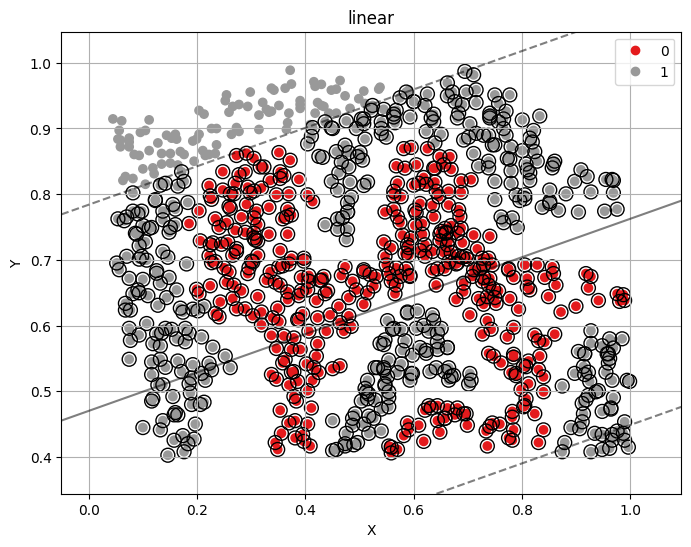

[I 2024-05-06 08:43:55,338] A new study created in memory with name: Minimize 1-mean(accuracy)
[I 2024-05-06 08:43:55,914] Trial 0 finished with value: 0.44378508420208507 and parameters: {'C': 0.32146882300365087, 'degree': 0}. Best is trial 0 with value: 0.44378508420208507.
[I 2024-05-06 08:43:57,421] Trial 1 finished with value: 0.4202485966319166 and parameters: {'C': 0.16929289605168607, 'degree': 9}. Best is trial 1 with value: 0.4202485966319166.
[I 2024-05-06 08:43:57,968] Trial 2 finished with value: 0.32248507529181125 and parameters: {'C': 0.009613207741136498, 'degree': 10}. Best is trial 2 with value: 0.32248507529181125.
[I 2024-05-06 08:43:58,412] Trial 3 finished with value: 0.21390002673082065 and parameters: {'C': 0.8372171910792325, 'degree': 2}. Best is trial 3 with value: 0.21390002673082065.
[I 2024-05-06 08:43:58,839] Trial 4 finished with value: 0.21275505658023686 and parameters: {'C': 0.18395801526359512, 'degree': 2}. Best is trial 4 with value: 0.2127550565

Best Params : {'C': 0.037468195635450674, 'degree': 2}

Best mean(accuracy) : 0.7891740176423416



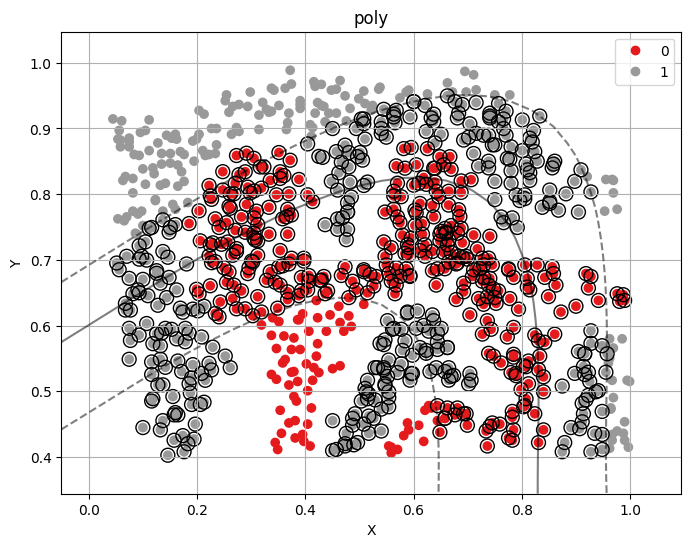

[I 2024-05-06 08:44:14,290] A new study created in memory with name: Minimize 1-mean(accuracy)
[I 2024-05-06 08:44:15,380] Trial 0 finished with value: 0.43644301880067726 and parameters: {'C': 0.4716560202023544, 'gamma': 766.2529813156003}. Best is trial 0 with value: 0.43644301880067726.
[I 2024-05-06 08:44:16,404] Trial 1 finished with value: 0.4406887641450594 and parameters: {'C': 0.4599301596581833, 'gamma': 997.7877628926486}. Best is trial 0 with value: 0.43644301880067726.
[I 2024-05-06 08:44:17,350] Trial 2 finished with value: 0.44378508420208507 and parameters: {'C': 0.21393074220896202, 'gamma': 327.9188846302109}. Best is trial 0 with value: 0.43644301880067726.
[I 2024-05-06 08:44:18,417] Trial 3 finished with value: 0.21013098102111727 and parameters: {'C': 0.8896577571826244, 'gamma': 472.651152839336}. Best is trial 3 with value: 0.21013098102111727.
[I 2024-05-06 08:44:19,937] Trial 4 finished with value: 0.39976833288781977 and parameters: {'C': 0.5740758451852054,

Best Params : {'C': 0.5465028622256111, 'gamma': 69.12649576225363}

Best mean(accuracy) : 0.9965116279069767



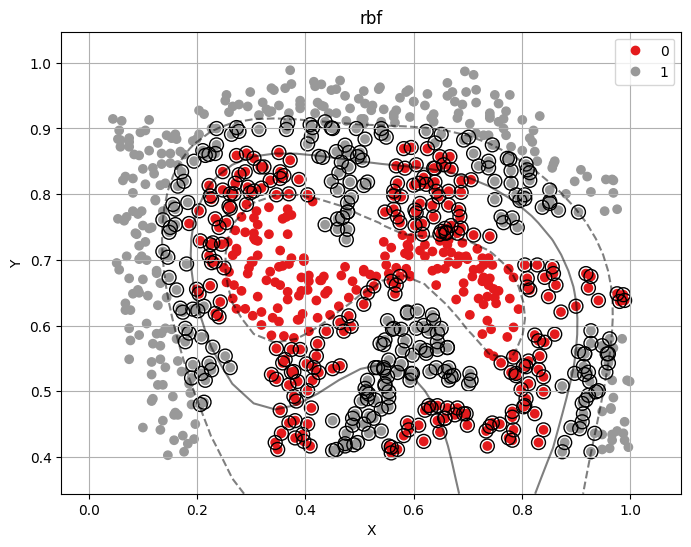

[I 2024-05-06 08:44:45,596] A new study created in memory with name: Minimize 1-mean(accuracy)
[I 2024-05-06 08:44:46,938] Trial 0 finished with value: 0.5056624788381003 and parameters: {'C': 0.7389565407127867, 'coef0': 0.3475634620506387}. Best is trial 0 with value: 0.5056624788381003.
[I 2024-05-06 08:44:48,298] Trial 1 finished with value: 0.6768110130981021 and parameters: {'C': 0.5670403663827558, 'coef0': -3.848448649808869}. Best is trial 0 with value: 0.5056624788381003.
[I 2024-05-06 08:44:49,117] Trial 2 finished with value: 0.6535641094181591 and parameters: {'C': 0.8032479940187348, 'coef0': -4.504044740254941}. Best is trial 0 with value: 0.5056624788381003.
[I 2024-05-06 08:44:49,906] Trial 3 finished with value: 0.6574489886839525 and parameters: {'C': 0.4855444000437499, 'coef0': -4.417100624662313}. Best is trial 0 with value: 0.5056624788381003.
[I 2024-05-06 08:44:50,580] Trial 4 finished with value: 0.5292167869553596 and parameters: {'C': 0.20295681738930926, 'c

Best Params : {'C': 0.26004867920102465, 'coef0': 1.2662344155900271}

Best mean(accuracy) : 0.5569901095963646



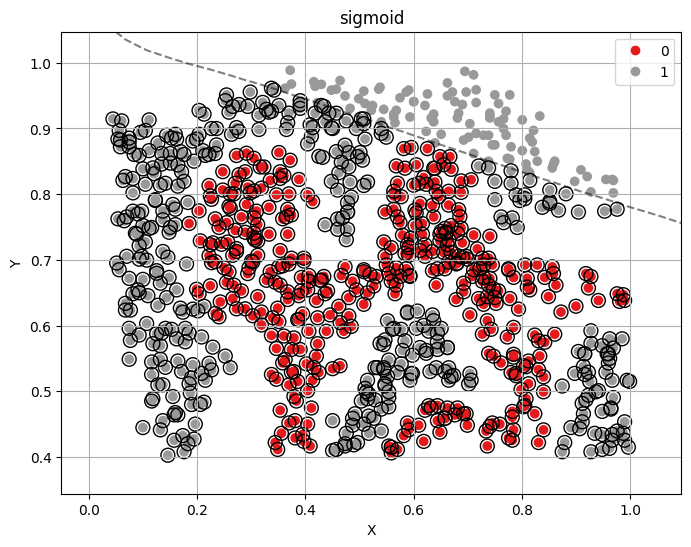

In [ ]:
# put your code here


## Homework 2

Use [ROC Curve visualizations](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) to compare the classifiers with the best values of paramters for each kernel.

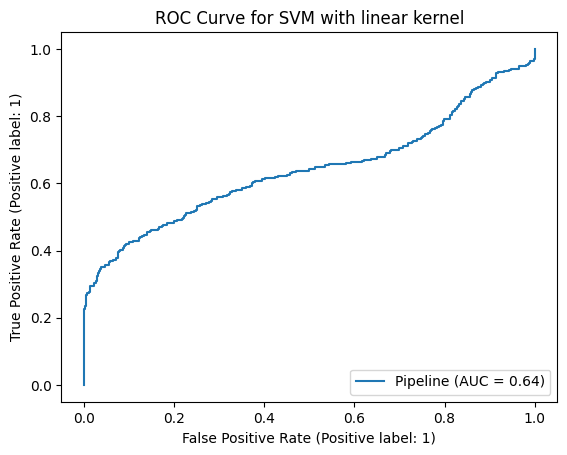

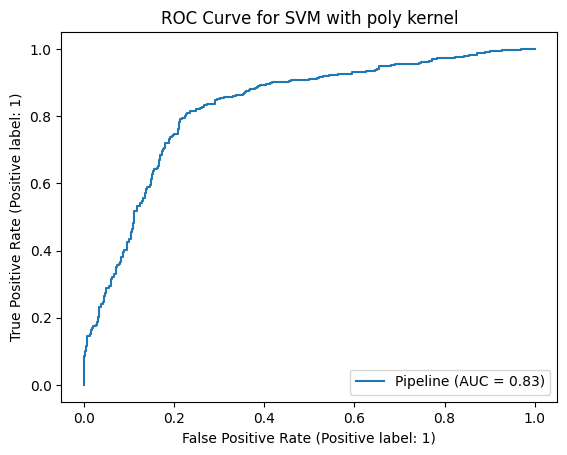

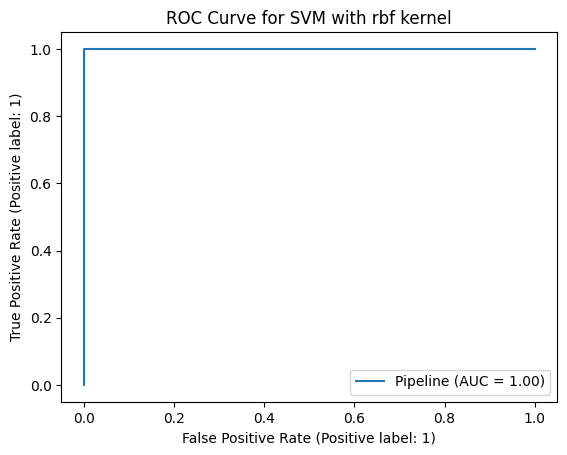

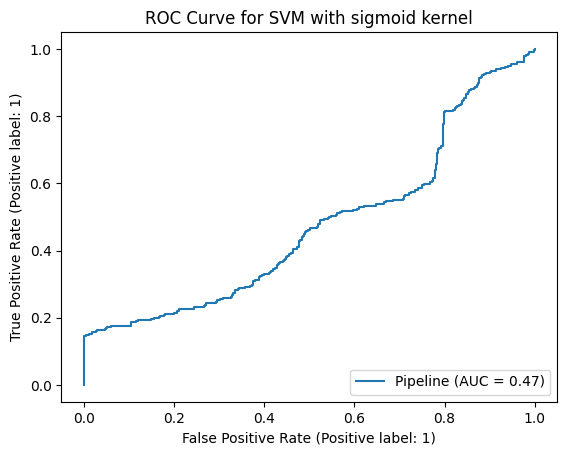

In [ ]:
# put your code here


## More than two classes
Unlike LDA, SVMs cannot be naturally extended to multiclass settings. Two general approaches are possible to make them work:
* one-versus-one --- make a classifier for all ${K\choose 2}$ distinct pairs of classes and count the number of times observation is assigned to each class, then assign to the most numerous one (see [OneVsOneClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html) in sklearn),
* one-versus-all --- fit K SVMs comparing chosen class to all the others at the same time, then assign to class for which $\beta_0+\beta_1x_1+\ldots+\beta_{n}x_n$ is the largest (see [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) in sklearn).

## Comparison with other methods

SVM work better than LR when the classes are separable or nearly separable (so does LDA). Otherwise SVM and LR (with ridge penalty) are very similar even though one is based on probabilistic model with some assumptions (that do not need to be satisfied).

SVM requires feature scalling, but regularized LR does so too. SVM handles outliers better.

Note that LR estimates probabilities, which can be very useful in some scenarios. For example SVM can only tell us is the tumor is malignant or benign, but LR can tell us if the probability is 51% or 99%. Yet, there are also ways to extend SVM with this feature see for example [this](https://scikit-learn.org/dev/modules/svm.html#scores-and-probabilities).

If boundaries are nonlinear, then SVMs are popular. We can use kernels with LR and LDA (see [this explanation](https://www.youtube.com/watch?v=J4rRXd9UL-A)), but it is more expensive computationaly. If you want to try it you can look at [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) and its [user guide](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge).

## Further reading/materials
* [Tutorial](https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/) with explanation of the basics
* [Sklearn SVM tutorial](https://scikit-learn.org/stable/modules/svm.html#svm-classification)
* [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) and [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* LIBSVM: A Library for Support Vector Machines ([paper](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf), [home page](https://www.csie.ntu.edu.tw/~cjlin/libsvm/))
* [Understanding SVM Hyperparameters](https://stackabuse.com/understanding-svm-hyperparameters/)
* [Ploting decision boundary](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py)

<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60">

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'>


Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej".   
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>